# Evaluate slot representation

In [1]:
import dnnlib
import torch
import legacy
from matplotlib import pyplot as plt
import numpy as np
from pg_modules.networks_fastgan import Generator
device = "cuda" if torch.cuda.is_available() else "cpu"
DATASET_NAME = "clevr"

In [2]:
def get_G(network_pkl):    
    print('Loading networks from "%s"...' % network_pkl)
    device = torch.device(
        'cuda') if torch.cuda.is_available() else torch.device('cpu')
    with dnnlib.util.open_url(network_pkl) as f:
        G = legacy.load_network_pkl(f)['G_ema'].to(device)  # type: ignore
    return G

In [3]:
G = Generator(slot_dim=64).to(device)

In [4]:
G_loaded = get_G("../../mlcloud_mount/models/pg-training-runs/00060-fastgan-clever6-gpus1-batch64-disc_d256_gen_feat8+16+32_no_tf_sa/network-snapshot.pkl")

Loading networks from "../../mlcloud_mount/models/pg-training-runs/00060-fastgan-clever6-gpus1-batch64-disc_d256_gen_feat8+16+32_no_tf_sa/network-snapshot.pkl"...


In [5]:
G.load_state_dict(G_loaded.state_dict(), strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['synthesis.slot_encoder.layers.0.self_attn.in_proj_weight', 'synthesis.slot_encoder.layers.0.self_attn.in_proj_bias', 'synthesis.slot_encoder.layers.0.self_attn.out_proj.weight', 'synthesis.slot_encoder.layers.0.self_attn.out_proj.bias', 'synthesis.slot_encoder.layers.0.linear1.weight', 'synthesis.slot_encoder.layers.0.linear1.bias', 'synthesis.slot_encoder.layers.0.linear2.weight', 'synthesis.slot_encoder.layers.0.linear2.bias', 'synthesis.slot_encoder.layers.0.norm1.weight', 'synthesis.slot_encoder.layers.0.norm1.bias', 'synthesis.slot_encoder.layers.0.norm2.weight', 'synthesis.slot_encoder.layers.0.norm2.bias', 'synthesis.slot_encoder.layers.1.self_attn.in_proj_weight', 'synthesis.slot_encoder.layers.1.self_attn.in_proj_bias', 'synthesis.slot_encoder.layers.1.self_attn.out_proj.weight', 'synthesis.slot_encoder.layers.1.self_attn.out_proj.bias', 'synthesis.slot_encoder.layers.1.linear1.weight', 'synthesis.slot_encoder.layers.1.linea

In [6]:
def get_image(G, slots, seed=1):
    torch.manual_seed(seed)
    z = torch.randn(slots.shape[0], G.z_dim).cuda()
    img = G(z, 0, truncation_psi=1, noise_mode="none", slots=slots)/2 + 0.5
    img = img.clamp(0, 1)
    return img

In [7]:
img = get_image(G, torch.randn(1, 7, 64).cuda())[0]

In [8]:
print(img.min())

tensor(0., device='cuda:0', grad_fn=<MinBackward1>)


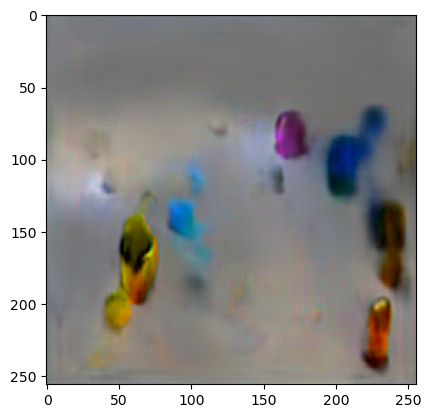

In [9]:
plt.imshow(img.permute(1, 2, 0).detach().cpu().numpy())

## Dataset

In [10]:
import os
import random
import json
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate
import json

class Image_Dataset(Dataset):
    def __init__(self, split='train', max_num_samples=np.inf, resolution=(128, 128), root_dir="/home/benedikthopf/Dokumente/9. Semester/datasets/CANDLE", filetype="png"):
        super(Image_Dataset, self).__init__()
        self.resolution = resolution

        assert split in ['train', 'val', 'test']
        self.split = split
        self.root_dir = root_dir
        # self.root_dir = "/home/benedikthopf/Dokumente/9. Semester/datasets/CLEVER/images/train"
        self.files = [file for file in os.listdir(
            self.root_dir) if file.endswith(f".{filetype}")]
        if len(self.files) > max_num_samples:
            self.files = self.files[:max_num_samples]
        self.img_transform = transforms.Compose([
            transforms.ToTensor()])

    def __getitem__(self, index):
        path = self.files[index]
        image = Image.open(os.path.join(self.root_dir, path)).convert("RGB")
        image = image.resize(self.resolution)
        image = self.img_transform(image)
        sample = {'image': image}

        return sample

    def __len__(self):
        return len(self.files)
    
class CLEVER(Image_Dataset):
    def __init__(self, split='train', max_num_samples=np.inf, max_num_objects=6, **kwargs):
        if "root_dir" not in kwargs.keys():
            kwargs["root_dir"] = "/home/benedikthopf/Dokumente/9. Semester/datasets/CLEVER/images/train"

        super().__init__(
            split,
            max_num_samples=np.inf,
            **kwargs
        )
        with open("/home/benedikthopf/Dokumente/9. Semester/datasets/CLEVER/scenes/CLEVR_train_scenes.json", "r") as f:
            scenes = json.load(f)

        self.max_num_objects = max_num_objects
        valid_scenes = list(filter(lambda x: len(
            x["objects"]) <= max_num_objects, scenes["scenes"]))
        valid_image_numbers = set(
            map(lambda x: x["image_filename"], valid_scenes))
        self.files = list(filter(
            lambda x: x in valid_image_numbers,
            self.files
        ))
        if len(self.files) > max_num_samples:
            self.files = self.files[:max_num_samples]

        self.files = sorted(self.files)
        self.scenes = sorted(valid_scenes, key=lambda x: x["image_filename"])

        with open("/home/benedikthopf/Dokumente/9. Semester/datasets/CLEVER/questions/CLEVR_train_questions.json", "r") as f:
            questions = json.load(f)["questions"]
        self.questions_by_image_index = {}
        for question in questions:
            i = question["image_index"]
            try:
                self.questions_by_image_index[i].append(question["question"])
            except KeyError:
                self.questions_by_image_index[i] = [question["question"]]

    def get_picture_object_count(self, file, scenes):
        for scene in scenes["scenes"]:
            if scene["image_filename"] == file:
                return len(scene["objects"])
        raise Exception(f"filename {file} not in scenes!")

    def __getitem__(self, index):
        path = self.files[index]
        image = Image.open(os.path.join(self.root_dir, path)).convert("RGB")
        image = image.resize(self.resolution)
        image = self.img_transform(image)

        o = self.scenes[index]["objects"]
        dummy = dict(o[0])
        dummy["shape"] = "None"  # dummy object, since the dataloader wants it
        objects = np.array([dummy for _ in range(self.max_num_objects)])
        for i in range(len(o)):
            objects[i] = o[i]
        objects = list(objects)

        sample = {
            'image': image,
            'question': np.random.choice(self.questions_by_image_index[index]),
            'objects': objects
        }

        return sample

## Slot attention

In [11]:
from pg_modules import ti_slots
use_ti_slots = False

In [12]:
sr = ti_slots.SlotRecreater().to(device)
sr.load_state_dict(torch.load(
    "../ti_slots/model --clip_dim=768, --feature_extractor=resnet18, masks, random_crop_85.ckpt")["model_state_dict"])
resolution = (128, 128)

In [13]:
train_set = CLEVER()

In [14]:
def show_tensor(t, ax=None):
    if ax:
        ax.imshow(t.permute(1, 2, 0).detach().cpu().numpy())
    else:
        plt.imshow(t.permute(1, 2, 0).detach().cpu().numpy())

In [15]:
def get_slots(img):
        with torch.no_grad():
            _, slots, _ = sr(img, center=use_ti_slots)
            slots = slots.detach()
        # slots = torch.zeros(img.shape[0], 7, 256).to("cuda:0")
        return slots

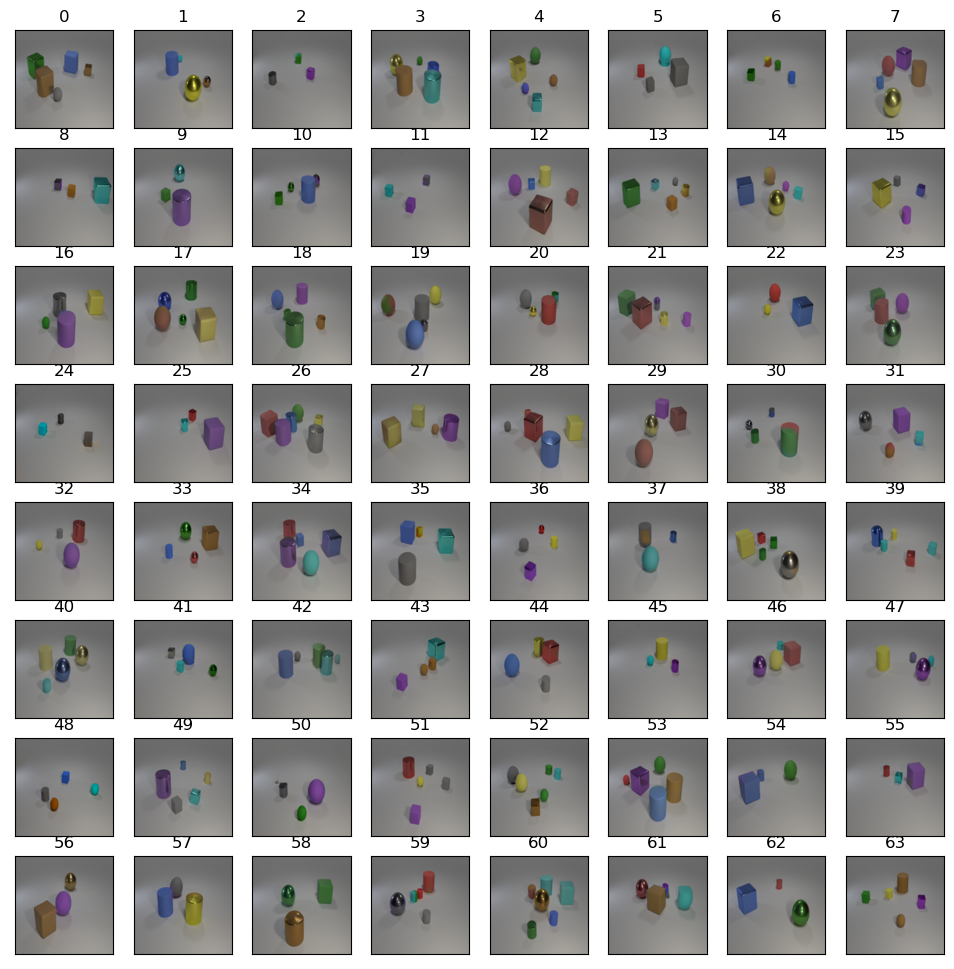

In [16]:
fig, axss = plt.subplots(8, 8, figsize=(12, 12))
i = 0
for axs in axss:
    for ax in axs:
        torch.manual_seed(1)
        slots = get_slots(train_set[i]["image"].to("cuda").unsqueeze(0))
        img = get_image(G, slots).squeeze()
        show_tensor(img, ax)
        ax.set_title(i)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        i += 1

In [20]:
img_1_nr = 3
img_2_nr = 4

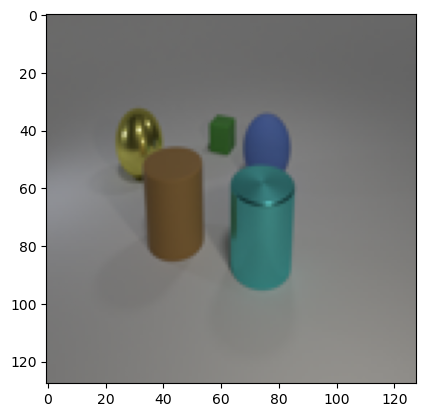

In [21]:
show_tensor(train_set[img_1_nr]["image"])

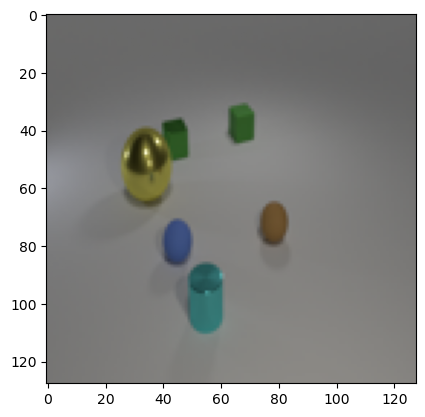

In [22]:
show_tensor(train_set[img_2_nr]["image"])

In [23]:
img1 = train_set[img_1_nr]["image"].to("cuda")
img2 = train_set[img_2_nr]["image"].to("cuda")

In [24]:
torch.manual_seed(1)
slots1 = get_slots(img1.unsqueeze(0))
torch.manual_seed(1)
slots2 = get_slots(img2.unsqueeze(0))

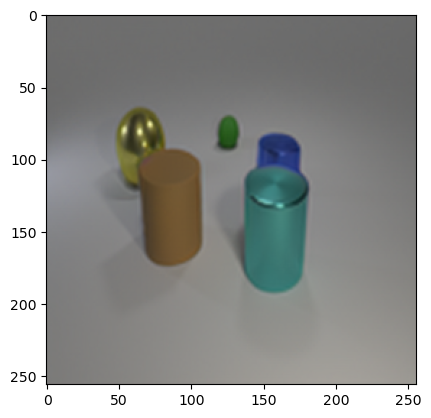

In [25]:
show_tensor(get_image(G, slots1)[0])

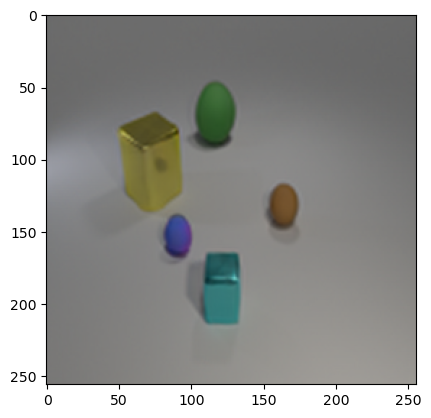

In [26]:
show_tensor(get_image(G, slots2)[0])

In [52]:
def show_interpolation(lmbd, index=-1):            
    if index < 0:
        slots = lmbd*slots1 + (1-lmbd)*slots2
    elif index == 7:
        slots = slots1.clone()
        slots[..., 0, :] = lmbd*slots1[..., 0, :] + (1-lmbd)*slots2[..., 0, :]
        slots[..., 1, :] = lmbd*slots1[..., 1, :] + (1-lmbd)*slots2[..., 1, :]
    else:
        slots = slots1.clone()
        slots[..., index, :] = lmbd*slots1[..., index, :] + (1-lmbd)*slots2[..., index, :]
    show_tensor(get_image(G, slots)[0])

In [53]:
from ipywidgets import interact, FloatSlider, IntSlider

In [55]:
interact(show_interpolation, lmbd=FloatSlider(min=0, max=1, value=0), index=IntSlider(min=-1, max=7, value=-1))

interactive(children=(FloatSlider(value=0.0, description='lmbd', max=1.0), IntSlider(value=-1, description='in…

<function __main__.show_interpolation(lmbd, index=-1)>

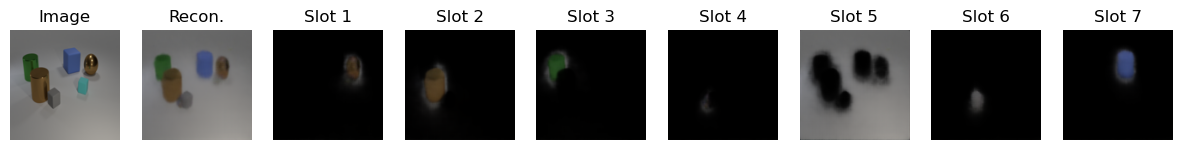

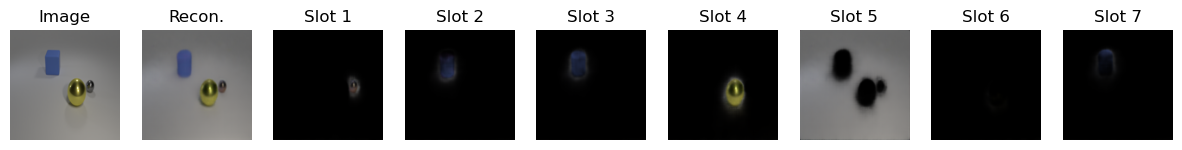

In [56]:
n_slots=7
for image in (img1, img2):
    image = image.clone().unsqueeze(0)

    torch.manual_seed(1)
    recon_combined, recons, masks, slots = sr.sa(image)
    recon_combined = recon_combined.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
    recons = recons.squeeze(0).clamp(0,1).cpu().detach().numpy()
    masks = masks.squeeze(0).clamp(0, 1).cpu().detach().numpy()
    
    fig, ax = plt.subplots(1, n_slots + 2, figsize=(15, 2))
    
    ax[0].imshow(image.squeeze(0).permute(1, 2, 0).detach().cpu().numpy())
    ax[0].set_title('Image')
    ax[1].imshow(recon_combined)
    ax[1].set_title('Recon.')
    for i in range(n_slots):
        ax[i + 2].imshow(recons[i] * masks[i])
        ax[i + 2].set_title('Slot %s' % str(i + 1))
    for i in range(len(ax)):
        ax[i].grid(False)
        ax[i].axis('off')

In [63]:
from PIL import Image
from tqdm import tqdm
import matplotlib

In [64]:
def save_tensor_image(filename, t, drange=(0, 1)):
    l, h = drange
    t = (t - l) / (h - l)
    return matplotlib.image.imsave(filename, t.permute(1, 2, 0).detach().cpu().numpy())

In [65]:
save_tensor_image(f"images/{DATASET_NAME}_real_{img_1_nr}.png", img1)
save_tensor_image(f"images/{DATASET_NAME}_fake_{img_1_nr}.png", get_image(G, slots1)[0])
save_tensor_image(f"images/{DATASET_NAME}_real_{img_2_nr}.png", img2)
save_tensor_image(f"images/{DATASET_NAME}_fake_{img_2_nr}.png", get_image(G, slots2)[0])
slots = slots1.clone()
#slots[..., 3, :] = slots2[..., 3, :]
#slots[..., 2, :] = slots2[..., 4, :]
#slots[..., 6, :] = slots2[..., 6, :]
lmbd = 0
slots[..., 1, :] = lmbd*slots1[..., 1, :] + (1-lmbd)*slots2[..., 1, :]
save_tensor_image(f"images/{DATASET_NAME}_composite_{img_1_nr}_{img_2_nr}.png", get_image(G, slots)[0])

# Interpolation

In [58]:
def do_interpolation(lmbd, index=-1):
    if type(index) == list:
        slots = slots1.clone()
        for i in index:
            slots[..., i, :] = lmbd*slots1[..., i, :] + (1-lmbd)*slots2[..., i, :]
    elif index < 0:
        slots = lmbd*slots1 + (1-lmbd)*slots2
    elif index == 7:
        slots = slots1.clone()
        slots[..., 0, :] = lmbd*slots1[..., 0, :] + (1-lmbd)*slots2[..., 0, :]
        slots[..., 1, :] = lmbd*slots1[..., 1, :] + (1-lmbd)*slots2[..., 1, :]
    else:
        slots = slots1.clone()
        slots[..., index, :] = lmbd*slots1[..., index, :] + (1-lmbd)*slots2[..., index, :]
    return get_image(G, slots)[0]

In [ ]:
images = []
for lmbd in tqdm(np.concatenate([np.linspace(0, 1, 60), np.linspace(1, 0, 60)])):
    img = do_interpolation(lmbd, index=[0, 2]).squeeze(0).cpu().detach().permute(1, 2, 0).numpy()
    img = (img * 255).astype(np.int8)
    img = Image.fromarray(img, mode="RGB")
    images.append(img)

In [ ]:
images[0].save("../demopictures/interpolation_dog_background.gif", 
               save_all=True, 
               append_images=images[1:], 
               duration=10,
               loop=0,
               optimize=True,
               include_color_table=True)

# PCA

In [ ]:
bs = 8
num_batches = 100
modslot=3

In [ ]:
for i in tqdm(range(num_batches)):
    batch = torch.stack([train_set[i*bs+j]["image"] for j in range(bs)]).to("cuda")
    dinosaur.add_to_PCA_dataset(batch, label_fn=lambda i, m: "ignored" if i != modslot else "")

In [ ]:
dinosaur.learn_PCA()

In [ ]:
def get_offset(coordinates, offsets, size=256):
    offset = np.zeros(size)
    for c, o in zip(coordinates, offsets):
        offset[c] = o
    return offset

In [ ]:
def show_pca(lmbd, i=0):
    _, _, _, _, slots = dinosaur.modify(train_set[37]["image"].unsqueeze(0).to("cuda"), get_offset([i], [lmbd]), modslot=modslot)
    show_tensor(get_image(G, slots).squeeze(0))

In [ ]:
interact(show_pca, lmbd=FloatSlider(min=-2, max=2, value=0), i=IntSlider(min=0, max=30, value=0))

In [ ]:
def do_pca(lmbd, i=0, modslot=modslot):
    _, _, _, _, slots = dinosaur.modify(train_set[37]["image"].unsqueeze(0).to("cuda"), get_offset([i], [lmbd]), modslot=modslot)
    return get_image(G, slots)

In [ ]:
images = []
for lmbd in tqdm(np.concatenate([np.linspace(-0.7, 1, 60), np.linspace(1, -0.7, 60)])):
    img = do_pca(lmbd, i=1, modslot=modslot).squeeze(0).cpu().detach().permute(1, 2, 0).numpy()
    img = (img * 255).astype(np.int8)
    img = Image.fromarray(img, mode="RGB")
    images.append(img)

In [ ]:
images[0].save("../demopictures/pca_dog_head_1.gif", 
               save_all=True, 
               append_images=images[1:], 
               duration=15,
               loop=0,
               optimize=True,
               include_color_table=True)